# Retail Fashion - Summary Demo

This is a notebook with a summary of the Industry Solution asset for Retail Fashion Data Cloud developed by Snowflake PolarIS team.

This full notebook runs within Snowpark Container Services as a demo.

## Use Case Sumary

Retailers use recommendation systems to advertise their products to customers in order to personalize customer experience online and at their stores. Doing so allows retailers to raise awareness to customers of products that match their style and tastes increasing number of items in their cart and the chances of a sale.

It is important to note that when creating these recommendations, we are not only taking into consideration the images of the product we are advertising, but also the customer's profile and their behavior online as well. Using all 3 of those data sources, we can create a truly personalized recommendation model that recommends different products to different customers.

## Storyline

The Retailer preprocesses the product image data through cropping, resizing, and other formatting processes. Using a pretrained image classification model (RESNET18), they use transfer learning in order to retrain the model on their image data, predicting classes specific to their product and store the model in Snowflake's staging area within Snowflake's cloud. 

They then create a UDF (User Defined Function) to perform downstream tasks to turn the images into image embeddings by retrieving the second to last layer in their deep learning model during these downstream tasks that are then encoded and stored in a datatable in Snowflake's database. 

The dimensions of the image data themselves are not interpretable or specific to any particular feature of the image. But the images that are similar in cosine similarity distances can be argued to be similar to each other in terms of visualizations. With these cosine similarity scores, the retailers can then create recommendations for similar products that our customers interact with.

## Solution Architecture

This is the full solution architecture, but this notebook condense most of that work in a single place in order to understand all the steps the solution is taking. For a full implementation using Snowpark Container Services, Snowpark Stored Procedures and Snowpark UDFs follow PolarIS full repository

![Architecture](Architecture_Solution.png)


## Pre-requisites

Here we are going to instal certain packages not included in the container or client used to run this notebook. This may very depending on your environment. Also we 

In [1]:
# Check libraries used for Snowflake
!pip list | grep snowflake

snowflake-connector-python    3.5.0
snowflake-ml-python           1.0.12
snowflake-snowpark-python     1.10.0


In [2]:
# Upload the latest one to the directory and install it

!pip install snowflake_ml_python-1.1.2-py3-none-any.whl --quiet

In [1]:
# RESTART THE KERNEL AND CHECK AGAIN to have at least 1.1.2 for snowflake-ml-python

!pip list | grep snowflake

snowflake-connector-python    3.5.0
snowflake-ml-python           1.1.2
snowflake-snowpark-python     1.10.0


In [2]:
#!pip install boto3 --quiet

## Flow
## Step 1: 
### Download Images that will be used for training

Images are available in a S3 bucket and we are going to download them in to an Internal Staging area

We are going to download the images that has been already pre-processed. We have images with these categories:

categories = ["blazer" ,"blouse" ,"body" ,"dress" ,"hat" ,"hoodie" ,"longsleeve" ,"not_sure" ,"other" ,"outwear", "pants" ,"polo" ,"shirt" ,"shoes" ,"shorts" ,"skirt" ,"t_shirt", "top" ,"undershirt"]

The raw images has been pre-processed with this kind of code:
<code>
image_paths = glob.glob('/workspace/images/test/*.jpg', recursive=True)
for path in tqdm.tqdm(image_paths):
    img = Image.open(path)
    if np.asarray(img).shape[-1] != 3:
        img = img.convert('RGB')
    w,h = img.size
    scale_factor = min(w/256, h/256)
    new_size = (int(w/scale_factor), int(h/scale_factor))
    img = img.resize(new_size)
    new_name = '_'.join(path.split('/')[-2:])
    img.save(f'/workspace/images/test/data_preprocessed/{new_name}')
</code>  


At the end each images is 256x256 and the file name contains the category before the first underscore (_)

the sfquickstarts contain all images but to save time we are just going to download the ones from data_preprocessed folder:


In [2]:
# This is the location within this container. This folder is mapped into a Staging Area, so all those images will be persisted within Snowflake

!mkdir -p /rapids/notebooks/workspace/images/data_preprocessed/

In [3]:
bucket_name = 'sfquickstarts'
download_dir = '/notebooks/workspace/images/data_preprocessed/'
prefixes = ['data_preprocessed/']

save_path = "/notebooks/workspace/models"


In [5]:
# Download files from public S3 bucket without having to provide AWS creds

import boto3
from botocore import UNSIGNED
from botocore.config import Config
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

i = 0
for prefix in prefixes:
    response = s3.list_objects(Bucket=bucket_name,Prefix='advanced_personalization_recommendation_engine/'+prefix)
    for key_obj in response['Contents']:
        if 'jpg' in key_obj["Key"]:
            key_obj_name = key_obj["Key"]
            #print(f'Downloading {key_obj_name}')
            download_filename = download_dir + key_obj_name.replace("advanced_personalization_recommendation_engine/data_preprocessed/","")
            s3.download_file(bucket_name, key_obj_name, download_filename)
            if i % 100 == 0:
                print (f'File {i} downloaded: {download_filename}')
            i += 1

File 0 downloaded: /notebooks/workspace/images/data_preprocessed/blazer_1683afd4-bb8e-45d0-af2c-41d199e6050e.jpg
File 100 downloaded: /notebooks/workspace/images/data_preprocessed/images_original_389824ae-be1f-4bd3-a1be-f62aad06477e.jpg
File 200 downloaded: /notebooks/workspace/images/data_preprocessed/longsleeve_d56ac277-03da-43cd-b7d2-b151b9bfa1fc.jpg
File 300 downloaded: /notebooks/workspace/images/data_preprocessed/pants_1e9ba1e2-eefe-4853-ab05-63598cb144f1.jpg
File 400 downloaded: /notebooks/workspace/images/data_preprocessed/shirt_661dc5c9-966c-483b-b579-feeb4acb7d3c.jpg
File 500 downloaded: /notebooks/workspace/images/data_preprocessed/shorts_dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
File 600 downloaded: /notebooks/workspace/images/data_preprocessed/t_shirt_d5332d88-114a-49b4-9f60-23efb19f363f.jpg


In [5]:
!ls /notebooks/workspace/images/data_preprocessed/ | wc -l

640


### Encoding Images into a Table
We use base64 encoding to encode our images into a column of byte strings for easy storage into our Snowflake Table. This will drastically increase the efficiency of loading our image dataset into Snowflake with zero loss of information and resolution. Afterwards, we will be checking that we can decode the images once again and then saving the final table into a Snowflake table within Snowflake cloud.

In [2]:
from IPython.display import display, HTML , Markdown
from snowflake.snowpark.session import Session
from PIL import Image
import pandas as pd
import logging
import tqdm
import glob
import numpy as np
import time
from IPython import display 


import os

In [7]:
%%time
# encode/decode

import base64
from io import BytesIO

def decode(data):
    return Image.open(BytesIO(base64.b64decode(data)))

# encode data into table

images = glob.glob(download_dir + "*.jpg")
labels = []
names = []
data = []
for img in tqdm.tqdm(images):
    names.append(img.split('/')[-1])
    label_cleaned = img.replace('t_shirt', 'tshirt') # We perform this cleaning here but should have being done before as part of data engineering
    labels.append(label_cleaned.split('/')[-1].split('_')[0])

    with open(img, "rb") as image_file:
        data.append(base64.b64encode(image_file.read()).decode("utf-8"))

df_base64 = pd.DataFrame(
    {
        'LABEL': labels,
        'NAME': names,
        'DATA': data
    }
)

100%|██████████| 640/640 [00:40<00:00, 15.78it/s]

CPU times: user 386 ms, sys: 142 ms, total: 528 ms
Wall time: 40.8 s


In [8]:
df_base64

,LABEL,NAME,DATA
0,blazer,blazer_1683afd4-bb8e-45d0-af2c-41d199e6050e.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,blazer,blazer_262f0622-cc35-46bb-8079-927b51fc3607.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,blazer,blazer_7533182e-fc68-44e0-aacb-1cf950c632b6.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,blazer,blazer_77f4bce5-ee55-46e6-844f-0468075386a6.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,blazer,blazer_cb24db34-d06c-4671-89a7-7f5e5eee7cdc.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
...,...,...,...
635,undershirt,undershirt_9e48ebba-5c0b-46f1-b1db-0046c41b4a7...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
636,undershirt,undershirt_9fe5fac7-f24e-4eb0-9315-0d2a89f3192...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
637,undershirt,undershirt_c6f8e37c-f09c-4721-ac92-c64494a6f00...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
638,undershirt,undershirt_e4691610-99fa-455e-b9ad-bd4816bb481...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


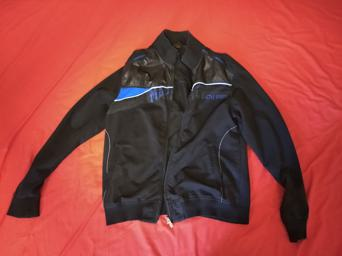

In [2]:
# What is wrong with this???????????

from IPython import display
display.Image("../images/data_preprocessed/blazer_1683afd4-bb8e-45d0-af2c-41d199e6050e.jpg", embed=True)

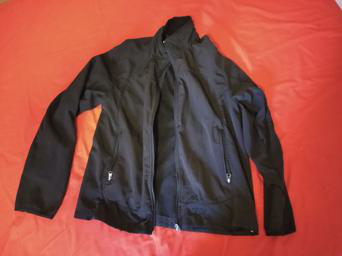

In [19]:
# check that we can decode data back into images
data = df_base64.DATA[2]
decode(data)

Let´s get a session handle for Snowflake account so we can save this into a table

In [3]:
def get_token():
    with open('/snowflake/session/token', 'r') as f:
        return f.read()

connection_params = {
    'host': os.environ['SNOWFLAKE_HOST'],
    'port': os.environ['SNOWFLAKE_PORT'],
    'protocol': 'https',
    'account': os.environ['SNOWFLAKE_ACCOUNT'],
    'authenticator': 'oauth',
    'token': get_token(),
    'role': 'SPCS_PSE_ROLE',
    'warehouse': 'CC_WH',
    'database': 'CC_RETAIL_ADV_PERSONALIZATION',
    'schema': 'PUBLIC'
}


session = Session.builder.configs(connection_params).create()
session.get_current_warehouse(), session.get_current_role(), session.get_current_database(), session.get_current_schema()

('"CC_WH"', '"SPCS_PSE_ROLE"', '"CC_RETAIL_ADV_PERSONALIZATION"', '"PUBLIC"')

In [13]:
%%time
# upload dataframe into snowflake table
sdf = session.create_dataframe(df_base64)
sdf.write.save_as_table(table_name="IMAGES_ENCODED", mode='overwrite')

CPU times: user 717 ms, sys: 33 ms, total: 750 ms
Wall time: 5.83 s


## Step 2: 
### Fine Tune Resnet 18 on the image dataset and convert it to a feature extractor for extracting image embeddings

This is the second step in the reference architecture diagram. 

We are going to Fine Tune a <b>ResNet18 Neural Network</b> using the images data set previously downloaded. The goal is to use it for feature extractor for image embeddings. This will be used later to show similar items when doing recomendations.

One of the key aspects here is using the second last layer of the Neural Network as the image embeddings

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import transforms, models
from torchvision.models._utils import IntermediateLayerGetter
from torch.utils.data import Dataset
import copy


This directory is also mapped into a STAGING AREA so models and notebooks are persisted within Snowflake

In [22]:
img_path = download_dir
anno_path = download_dir


In [23]:
df = session.table("IMAGES_ENCODED")

classes = df.select("LABEL").distinct().to_pandas()


These are the classes that will be used to run the classificaiton training, altough we are interested in the second last layer of the neural network that will be captured as output and used as embeddings

In [24]:
print (classes)

         LABEL
0       blazer
1       blouse
2         body
3        dress
4          hat
5       hoodie
6       images
7   longsleeve
8          not
9      outwear
10       pants
11        polo
12       shoes
13      shorts
14       skirt
15      tshirt
16         top
17  undershirt
18       other
19       shirt


In [25]:
class_mapping= {c: i for i, c in enumerate(classes['LABEL'])}


In [26]:
class_mapping['shirt']

19

In [27]:
# set device, will automatically select cuda/mps is GPUs/apple silicone are available
if not torch.backends.mps.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("mps")
    
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [28]:
device

device(type='cpu')

In [22]:
# custom dataset class, builds dataset from provided table dataframe
class CustomImageDataset(Dataset):
    def __init__(self, df_annotations, img_dir, transform=None, target_transform=None):
        self.img_labels = df_annotations
        self.classes = list(class_mapping.keys())
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 0]
        label = class_mapping[label] # map string label to integer
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [23]:
# create datasets/dataloaders for train and val using the appropriate annotation file and transform

train_df, val_df = session.table("IMAGES_ENCODED").random_split(weights=[0.8, 0.2], seed=0)

image_datasets = {
    'train': CustomImageDataset(
        df_annotations = train_df.to_pandas(),
        img_dir = img_path,
        transform = data_transforms['train']
    ),
    'val': CustomImageDataset(
        df_annotations = val_df.to_pandas(),
        img_dir = img_path,
        transform = data_transforms['val']
    ),    
}

In [24]:

# create dataloaders for train and val with specified batch size
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=16,
        shuffle=True, 
        num_workers=4)
    for x in ['train', 'val']
}


In [25]:
# get dataset sizes and class names, used in some computations later
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# initialize model with pretrained weights
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# add classification head for fine tuning and move to device
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# set loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


In [26]:
# Model Training Loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
%%time

# start training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 2.7551 Acc: 0.1842


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


val Loss: 2.4322 Acc: 0.2870

Epoch 1/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 2.2525 Acc: 0.3590


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


val Loss: 2.0566 Acc: 0.3981

Epoch 2/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 1.9406 Acc: 0.4342


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


val Loss: 1.8896 Acc: 0.4537

Epoch 3/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 1.7079 Acc: 0.5094


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


val Loss: 1.7544 Acc: 0.4815

Epoch 4/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


train Loss: 1.5010 Acc: 0.5695


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


val Loss: 1.7401 Acc: 0.5000

Epoch 5/24
----------


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


train Loss: 1.4021 Acc: 0.5883


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


val Loss: 1.6456 Acc: 0.5556

Epoch 6/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.08it/s]


train Loss: 1.3260 Acc: 0.6165


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


val Loss: 1.6364 Acc: 0.5093

Epoch 7/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 1.0961 Acc: 0.6992


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


val Loss: 1.5796 Acc: 0.5648

Epoch 8/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


train Loss: 1.0985 Acc: 0.6880


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


val Loss: 1.5556 Acc: 0.5741

Epoch 9/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.07it/s]


train Loss: 1.0888 Acc: 0.6955


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


val Loss: 1.5288 Acc: 0.6111

Epoch 10/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.07it/s]


train Loss: 1.0948 Acc: 0.6936


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


val Loss: 1.5700 Acc: 0.5741

Epoch 11/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


train Loss: 1.0602 Acc: 0.7049


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


val Loss: 1.5636 Acc: 0.5833

Epoch 12/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.08it/s]


train Loss: 1.0721 Acc: 0.6955


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


val Loss: 1.5555 Acc: 0.5648

Epoch 13/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.06it/s]


train Loss: 1.0309 Acc: 0.7030


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


val Loss: 1.5367 Acc: 0.5648

Epoch 14/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


train Loss: 1.0185 Acc: 0.7105


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


val Loss: 1.5456 Acc: 0.5741

Epoch 15/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


train Loss: 1.0388 Acc: 0.7124


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


val Loss: 1.5651 Acc: 0.5833

Epoch 16/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.06it/s]


train Loss: 0.9935 Acc: 0.7218


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


val Loss: 1.5504 Acc: 0.5833

Epoch 17/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.06it/s]


train Loss: 0.9881 Acc: 0.7218


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


val Loss: 1.5553 Acc: 0.5833

Epoch 18/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 0.9989 Acc: 0.7068


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


val Loss: 1.5410 Acc: 0.5648

Epoch 19/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.06it/s]


train Loss: 1.0448 Acc: 0.7030


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


val Loss: 1.5685 Acc: 0.5648

Epoch 20/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.06it/s]


train Loss: 1.0270 Acc: 0.7180


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


val Loss: 1.5547 Acc: 0.6019

Epoch 21/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.07it/s]


train Loss: 1.0475 Acc: 0.6917


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


val Loss: 1.5395 Acc: 0.6019

Epoch 22/24
----------


100%|██████████| 34/34 [00:31<00:00,  1.07it/s]


train Loss: 0.9762 Acc: 0.7162


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


val Loss: 1.5328 Acc: 0.5926

Epoch 23/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


train Loss: 1.0128 Acc: 0.7162


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


val Loss: 1.5325 Acc: 0.5648

Epoch 24/24
----------


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


train Loss: 1.0041 Acc: 0.7312


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

val Loss: 1.5358 Acc: 0.5926

Training complete in 14m 35s
Best val Acc: 0.611111
CPU times: user 53min 34s, sys: 2min 21s, total: 55min 56s
Wall time: 14min 35s


In this next step we are saving two models one is the model that we have trained and that will be able to classify the picture. In reality that model is not used.

Next we are using:

<b>new_m = IntermediateLayerGetter(model_ft, {'avgpool': 'features'})</b>

To extract the 'avgpool' layer and using it as the embeddings of the images. Simlar images will result in similar embeddings.

That model is saved as embedding_model.pt and will be used later to extract embeddings or new images that we will use to find simlar images (cloths)

In [28]:

# save best model
best_model_file = os.path.join(save_path, 'best_model.pt')
torch.save(model_ft, best_model_file)

# create embedding model
new_m = IntermediateLayerGetter(model_ft, {'avgpool': 'features'})
new_m = new_m.to('cpu')

# save embedding model
embedding_model_file = os.path.join(save_path, 'embedding_model.pt')
torch.save(new_m, embedding_model_file)

print(f'Saved Models\n Best Model: {best_model_file}\n Embedding Model:{embedding_model_file}')

Saved Models
 Best Model: /notebooks/workspace/models/best_model.pt
 Embedding Model:/notebooks/workspace/models/embedding_model.pt


## Step 3: Image Embedding Inference

This is the step 3 of the reference architecture. Here we are creating a UDF based on the embedding model that has been previously created. For any given image, that UDF will return the embeddings that will be used in the next step to find similar items

Note we have stored the model withn the directory "/rapids/notebooks/workspace/models/" but that is mapped into the MODEL Staging Area. Check:

In [29]:
session.sql('ls @MODELS').collect()

[Row(name='models/.ipynb_checkpoints/0_preprocessing_and_uploading-checkpoint.ipynb', size=180886, md5='6d2e3a41f909544cd454de27ae27af62', last_modified='Fri, 10 Nov 2023 12:27:06 GMT'),
 Row(name='models/.ipynb_checkpoints/CC_end_to_end-checkpoint.ipynb', size=1509860, md5='fb6c8d81aa23ec713a55168b5b1f0a26', last_modified='Wed, 13 Dec 2023 11:00:31 GMT'),
 Row(name='models/.ipynb_checkpoints/ONCALL_CC_end_to_end-checkpoint.ipynb', size=1737195, md5='e970849ef33fc164f98d8831daeb4e82', last_modified='Tue, 12 Dec 2023 22:07:06 GMT'),
 Row(name='models/.ipynb_checkpoints/cc_clickstream_data_generation-checkpoint.ipynb', size=46189935, md5='35a103014b1065d987eb11e17e661dad-1', last_modified='Wed, 15 Nov 2023 22:21:08 GMT'),
 Row(name='models/.ipynb_checkpoints/copy_CC_end_to_end-checkpoint.ipynb', size=1291277, md5='e706f9c5c750eb0da8f601f8513d5780', last_modified='Wed, 29 Nov 2023 15:11:50 GMT'),
 Row(name='models/.ipynb_checkpoints/data_raw-checkpoint.py', size=1217, md5='cd92f4bca5ea64a

In [30]:
from snowflake.snowpark.functions import udf, col
from cachetools import cached
import json

In [31]:
session.sql("create or replace stage UDF_STG").collect()

[Row(status='Stage area UDF_STG successfully created.')]

### UDF embedding
We define a few functions:

load_model: loads our pytorch model
load_transform: transforms our data appropriately through resizing, normalizing, and cropping, etc.
UDF (udf)torch_embedding_model: Calls the 2 functions above in order to load the model, decode the data from the datatable, transform the data, and performs downstream tasks on the data
Then we read in our encoded images

Then we perform inference on our encoded images using the UDF we defined earlier, and save the table as IMAGE_ENCODED within snowflake

We then visualize the table "IMAGE_ENCODED" to make sure the encoded images as well as the image embeddings are present

In [32]:

session.add_packages("cachetools", "pillow", "torchvision", "pytorch")

@cached(cache={})
def load_model(model_path: str) -> object:
    import torch
    model = torch.load(model_path)
    return model

@cached(cache={})
def load_transform() -> object:
    from torchvision import transforms
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return data_transforms

@udf(name='udf_torch_embedding_model',session=session,replace=True,is_permanent=True,
     stage_location='@UDF_STG',imports=['@MODELS/embedding_model.pt'])
def udf_torch_embedding_model(data: str) -> str:
    import sys
    import json
    import base64
    from io import BytesIO
    from PIL import Image
    
    
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'embedding_model.pt'
    model = load_model(import_dir+model_name)
    transform = load_transform()
    
    img = Image.open(BytesIO(base64.b64decode(data)))
    img = transform(img).unsqueeze(0) 
    with torch.no_grad():
        embedding = model(img)['features'].squeeze()
    
    output = json.dumps([round(float(x), 3) for x in embedding])
    return output


The version of package 'cachetools' in the local environment is 4.2.4, which does not fit the criteria for the requirement 'cachetools'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'torchvision' in the local environment is 0.16.0, which does not fit the criteria for the requirement 'torchvision'. Your UDF might not work when the package version is different between the server and your local environment.
Package 'pytorch' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


In [33]:
session.get_current_warehouse(), session.get_current_role(), session.get_current_database(), session.get_current_schema()

('"CC_WH"', '"SPCS_PSE_ROLE"', '"CC_RETAIL_ADV_PERSONALIZATION"', '"PUBLIC"')

In [34]:
# we use the table created in preprocessing_and_uploading.ipynb
sdf = session.table('IMAGES_ENCODED')
scored_sdf = sdf.with_column('EMBEDDING', udf_torch_embedding_model('DATA'))

NOTE: From December we will be able to use the new Vector type to store the embeddings

In [35]:
%%time
# write embeddings into snowflake (executed embedding model)
scored_sdf.write.save_as_table(table_name='IMAGES_ENCODED_EMBEDDINGS2', mode='overwrite')

CPU times: user 827 µs, sys: 7.5 ms, total: 8.33 ms
Wall time: 15 s


For reference, time using STANDARD_2 CPU Compute pool:
    
    CPU times: user 20.4 ms, sys: 32 µs, total: 20.4 ms
    Wall time: 1min 35s
    
Using GPU_3:

    Wall time 16s

In [36]:
sdf2 = session.table("IMAGES_ENCODED_EMBEDDINGS")
sdf2.limit(5).to_pandas()

,LABEL,NAME,DATA,EMBEDDING
0,blazer,blazer_d55fe704-5e35-4eea-a0a6-fa09f759a978.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[1.647, 0.34, 0.394, 1.107, 2.211, 0.1, 2.541,..."
1,body,body_e8e02e60-7983-4b57-9095-cf9512bb9b1b.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[2.366, 0.408, 1.731, 0.954, 0.61, 0.463, 0.21..."
2,dress,dress_20a31e9d-f1d8-4eaf-9edd-9b1a8b59799a.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[1.376, 1.135, 0.578, 0.714, 0.338, 4.594, 0.0..."
3,dress,dress_4068d0b4-56a5-4108-85c4-7c48c201147f.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[1.224, 0.095, 0.288, 0.994, 0.655, 3.8, 0.555..."
4,dress,dress_7ac347b0-0147-4f0e-8174-c40177d53287.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.124, 0.237, 0.34, 1.23, 0.303, 0.438, 0.301..."


In [37]:
sdf2.schema

StructType([StructField('LABEL', StringType(16777216), nullable=True), StructField('NAME', StringType(16777216), nullable=True), StructField('DATA', StringType(16777216), nullable=True), StructField('EMBEDDING', StringType(16777216), nullable=True)])

## Step 4: Image Similarity Search

This next part visualizes the results of running the image embeddings retrieved from the last part through cosine similarity scores in order to find recommendations of clothing based on other clothing products selected.

- First we read in our encoded images table
- Then we run cosine similarity on all combinations of the image embeddings to get a similarity matrix
- then we define 3 helper functions:
    - get_image: gets the image based on image name and returns image and label of image
    - visualize_model: given a dataframe, and number of images we want to display, this function displays all the images referenced in the dataframe by leveraging "get_image"
    - given the similarity matrix, image to reference, and other parameters, it displays the top n images based on based on the image to reference by leveraging "visualize_model"
- We then show how to look up an example item to display through the file name
- We plug in the example item into our top_n function to get all the recommmendations for dresses
- We then show how to do it again for other labels such as hoodies, pants, and blazers

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

embeddings = sdf2.select("EMBEDDING", "NAME").to_pandas()

embeddings_np = list(embeddings['EMBEDDING'].apply(lambda x: np.array(json.loads(x))))

similarity=cosine_similarity(embeddings_np)

sim_df = pd.DataFrame(similarity, 
                      columns=embeddings.NAME, 
                      index=embeddings.NAME)

In [39]:
sim_df

NAME,blazer_d1df1763-f51c-4701-9c6b-a76f1b6739e8.jpg,body_814dbf98-4963-47c9-8894-f8e44088272c.jpg,dress_1da10477-cb53-4506-b54c-1ad949002e35.jpg,dress_3eeaf330-2460-4d7f-844f-d7254d12e587.jpg,dress_7aa53761-7711-4850-b94e-9d8ae3272320.jpg,dress_ae6f7084-8025-4ac5-9326-1f5db4e61305.jpg,dress_d69680eb-4fdc-4783-b0d3-3b453f50069b.jpg,hat_14d9f39c-48f5-4da6-bea4-b9f8b94633ed.jpg,hat_c399e385-258a-465c-95d1-ba216c16d7d1.jpg,hat_f18043dd-b667-41c4-ba80-38299c49c399.jpg,...,t_shirt_711549c2-fc5d-469d-b099-4a9e1a73a9be.jpg,t_shirt_8713b1fa-9037-4657-8eda-084d4e147dce.jpg,t_shirt_9bd47c09-cd05-4d03-8968-5ad91ed24a2b.jpg,t_shirt_b602653d-ecac-482d-abac-710a440ba811.jpg,t_shirt_bf79cec3-700a-428d-95c9-83cfd923d606.jpg,t_shirt_d5a61162-1cdb-4d17-8a19-c340d59d1a99.jpg,t_shirt_e7d4544f-a4d5-4fde-aedb-dd9117a68b31.jpg,t_shirt_ff84e74e-d53f-43c5-9ba6-351f665e2637.jpg,undershirt_333966d4-9bb2-48b0-b0a4-489542338877.jpg,undershirt_93e4b772-7c69-46b7-af82-b3d270fa3438.jpg
NAME,,,,,,,,,,,,,,,,,,,,,
blazer_d1df1763-f51c-4701-9c6b-a76f1b6739e8.jpg,1.000000,0.619384,0.609670,0.503308,0.681137,0.622614,0.515630,0.498192,0.503376,0.457634,...,0.567749,0.536447,0.517950,0.553148,0.539866,0.590964,0.542875,0.568812,0.546020,0.571025
body_814dbf98-4963-47c9-8894-f8e44088272c.jpg,0.619384,1.000000,0.558481,0.561818,0.643941,0.632233,0.620708,0.552958,0.565471,0.551485,...,0.579783,0.596036,0.594181,0.731398,0.652200,0.678303,0.576715,0.629830,0.627844,0.654007
dress_1da10477-cb53-4506-b54c-1ad949002e35.jpg,0.609670,0.558481,1.000000,0.559366,0.670125,0.669413,0.626326,0.515396,0.521565,0.483500,...,0.488640,0.582106,0.488658,0.522591,0.490936,0.543575,0.406832,0.575271,0.463387,0.505314
dress_3eeaf330-2460-4d7f-844f-d7254d12e587.jpg,0.503308,0.561818,0.559366,1.000000,0.578659,0.604801,0.631371,0.499065,0.468226,0.445768,...,0.534850,0.585046,0.579890,0.527641,0.593880,0.559531,0.560137,0.509516,0.477500,0.597147
dress_7aa53761-7711-4850-b94e-9d8ae3272320.jpg,0.681137,0.643941,0.670125,0.578659,1.000000,0.684142,0.524356,0.504285,0.515026,0.550540,...,0.564622,0.603112,0.561293,0.583780,0.597501,0.548761,0.516547,0.537762,0.539450,0.615687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t_shirt_d5a61162-1cdb-4d17-8a19-c340d59d1a99.jpg,0.590964,0.678303,0.543575,0.559531,0.548761,0.703388,0.548412,0.496419,0.467011,0.408202,...,0.589839,0.649669,0.676354,0.688340,0.687081,1.000000,0.688903,0.626604,0.598210,0.662395
t_shirt_e7d4544f-a4d5-4fde-aedb-dd9117a68b31.jpg,0.542875,0.576715,0.406832,0.560137,0.516547,0.541672,0.475070,0.396864,0.386739,0.378232,...,0.550442,0.556141,0.615092,0.614837,0.705257,0.688903,1.000000,0.565656,0.556833,0.660094
t_shirt_ff84e74e-d53f-43c5-9ba6-351f665e2637.jpg,0.568812,0.629830,0.575271,0.509516,0.537762,0.559362,0.558462,0.464301,0.455256,0.533271,...,0.612128,0.641746,0.615937,0.607609,0.594188,0.626604,0.565656,1.000000,0.563426,0.611835


In [40]:
import matplotlib.pyplot as plt

sdf = session.table("IMAGES_ENCODED_EMBEDDINGS")
name_col = "NAME"
data_col = "DATA"
label_col = "LABEL"

# retreive image and label from snowflake DB for a given file name
def get_image(img_name):
    data = sdf.filter(col(name_col) == img_name).select(label_col, data_col).to_pandas()
    img = Image.open(BytesIO(base64.b64decode(data[data_col][0])))
    label = data[label_col][0]
    return img, label

def visualize_model(df, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for row in df.iterrows():
        item = row[0]
        sim_score = row[1].values[0]
        
        img, label = get_image(item)
        img = np.asarray(img)
        
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'Label: {label}, Similarity: {sim_score:.2}')
        plt.imshow(img);

        if images_so_far == num_images:
            return
        
# Finds top N most similar items for an input item and can display them
def top_n(sim_df, item, n=10, plot_n=None, visualize = True, best=True):
    if best:
        df = sim_df[[item]].sort_values(item, ascending=False)[1:].head(n) # top n
    else: 
        df = sim_df[[item]].sort_values(item, ascending=True).head(n) # bottom n
        
    if visualize:
        img, label = get_image(item)
        
        img = np.asarray(img)
        plt.imshow(img);
        plt.title(label)
       
        if plot_n is None:
            plot_n = n
        visualize_model(df, num_images=plot_n)

    return df

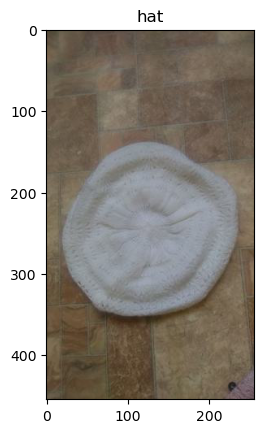

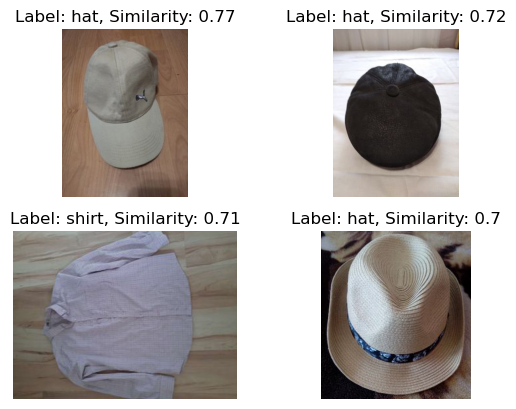

In [41]:
img_names = session.table("IMAGES_ENCODED_EMBEDDINGS").select("NAME").to_pandas()

item = img_names.NAME[7]
df = top_n(sim_df, item, n=4)

CPU times: user 587 ms, sys: 7.4 ms, total: 594 ms
Wall time: 3.61 s


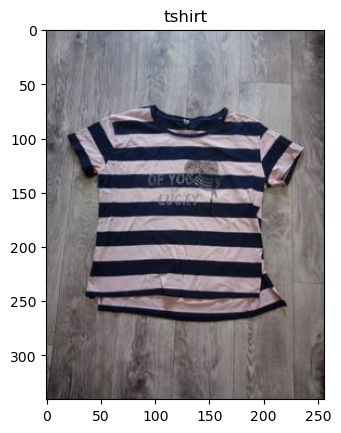

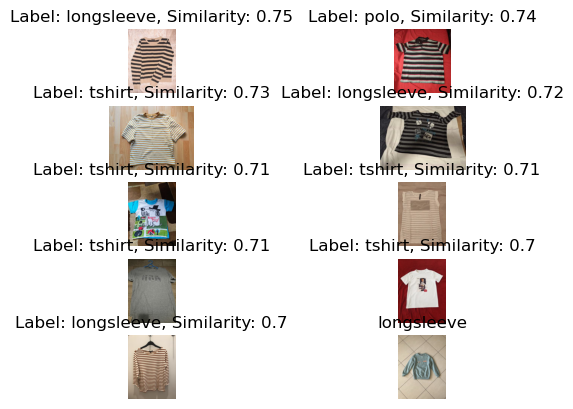

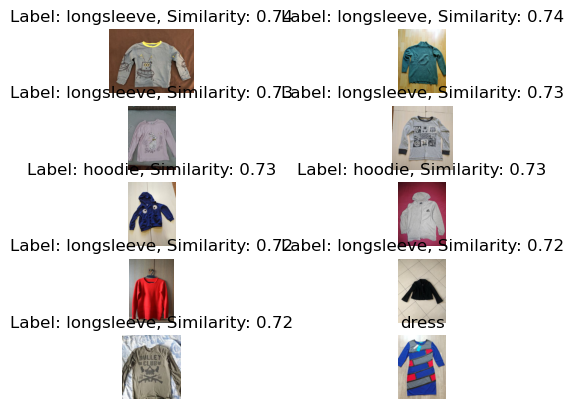

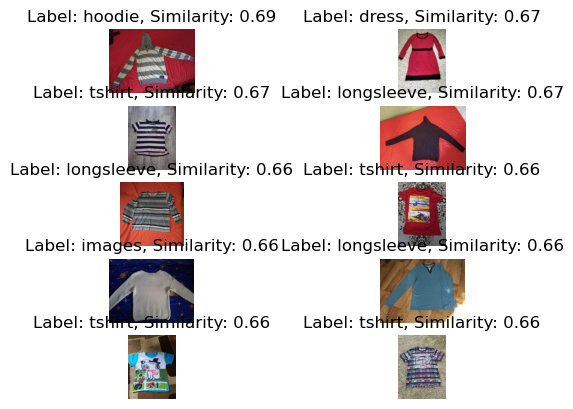

In [42]:
%%time

import random
item = img_names.NAME
index=random.sample(range(0, len(item)), 3)
items=item[index]
df = [top_n(sim_df, item) for item in items]
    

## Step 7: Personalization Dataset

In this setp a personalized dataset will be created using clickstream data plus the image embeddings created in the previous steps. The results will be a table wihin Snowflake that will be used in the next step to make and advanced personalization training.

That table can be created from scratch using zzz_clickstream_data_generation.ipynb for the purposes of running this notebook and testing this code but each retailer will provide different information, so this is used for demo purposes.

The first step in that notebook is to create a dataframe with the Customers.csv file that is provided with this example. 

This file is used to generaty synthetic data. We start with 

- Customer ID
- Gender

Add features that are mapped to cluster of people
- Salary
- Profession
- Work Experience
- Family Size
- Annual Income
- Spending score

That data generated is used with the IMAGES_ENCODED table previously generated. That is used to describe clothes based on trends observed in the embedding for each category, gender and age. E.g mini skirts are associated with the female gender and a younger audience. So for each cloth an age_affinity and gender_affinity is created. 

This Final_Personalizatoin_Full table is shown in the next table. For each customer we have all their attributes for gender, age, spending_score etc. For each customer we have the cloths that have visited and in the Clickstream column we may have the following values:
- Seen
- Click
- Add2Cart
- Purchase

INTERACTION column represent the numerical value of Clickstream:

- 0 : Seen
- 1 : Seen + click
- 2 : Seen + click + Add2Cart
- 3 : Seen + click + Add2Cart + Purchase



In [29]:
df = session.table("Final_Personalization_Full")
df.limit(10).to_pandas()

,CUSTOMERID,NAME,SCORE,GENDER,AGE,PROFESSION,WORK_EXPERIENCE,ANNUAL_INCOME,SPENDING_SCORE,FAMILY_SIZE,EMBEDDINGS,Clickstream,INTERACTION
0,1401,longsleeve_2e2caac6-b1a0-4466-a998-0fa5f155481...,0.319567,Female,35,Executive,14,181457.06501,36,4,"[1.011, 0.852, 0.577, 0.905, 0.188, 0.453, 1.2...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
1,1401,longsleeve_3131d235-b604-4170-b078-bc1d86f2694...,0.248926,Female,35,Executive,14,181457.06501,36,4,"[0.93, 0.81, 1.365, 0.775, 2.001, 1.085, 1.958...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
2,1401,longsleeve_31c0316b-d4b5-4c93-809d-a7d97f6c077...,0.316920,Female,35,Executive,14,181457.06501,36,4,"[4.438, 0.802, 0.053, 0.377, 1.695, 1.364, 1.3...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
3,1401,longsleeve_387d935f-a648-4d15-9aca-ae74c1e7b2a...,0.180566,Female,35,Executive,14,181457.06501,36,4,"[0.985, 1.799, 0.154, 0.578, 0.605, 3.249, 0.2...","[\n ""Seen"",\n ""Click""\n]",1
4,1401,longsleeve_3e6352b9-9e25-4de0-a568-9446d8f6192...,0.316142,Female,35,Executive,14,181457.06501,36,4,"[0.846, 1.173, 1.459, 0.536, 2.159, 0.943, 1.9...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
5,1401,longsleeve_414cf5c9-f0eb-4f7e-a20a-7ef77ef2e06...,0.299802,Female,35,Executive,14,181457.06501,36,4,"[0.421, 0.196, 2.941, 1.078, 0.839, 2.186, 0.9...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
6,1401,longsleeve_427d9739-ea21-4885-b9c2-31ccde4af5f...,0.076167,Female,35,Executive,14,181457.06501,36,4,"[0.279, 2.257, 2.671, 2.793, 1.153, 1.796, 2.9...","[\n ""Seen""\n]",0
7,1401,longsleeve_42c30a48-5e35-4117-847d-66cad138395...,0.258149,Female,35,Executive,14,181457.06501,36,4,"[0.954, 0.965, 0.247, 1.677, 1.266, 0.41, 0.92...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
8,1401,longsleeve_46d65d04-97a1-4bf3-bc3e-67c835a86fb...,0.215981,Female,35,Executive,14,181457.06501,36,4,"[2.037, 0.115, 0.406, 0.448, 2.018, 1.742, 1.2...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2
9,1401,longsleeve_4e0f02de-645d-4615-a13b-749d8027c85...,0.247867,Female,35,Executive,14,181457.06501,36,4,"[0.016, 1.524, 0.314, 0.897, 0.427, 0.137, 0.3...","[\n ""Seen"",\n ""Click"",\n ""Add2Cart""\n]",2


## Step 8: Advanced Personalization Training

Using the previous generated table a new model will be training in this step

In [5]:
import snowflake.snowpark.functions as F

from snowflake.ml.modeling.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from snowflake.ml.modeling.pipeline import Pipeline

In [31]:
train_df, test_df = session.table("Final_Personalization_Full").random_split(weights=[0.8, 0.2], seed=0)

train_df.write.save_as_table(table_name='CLICKSTREAM_TRAIN_FULL', mode='overwrite')
test_df.write.save_as_table(table_name='CLICKSTREAM_TEST_FULL', mode='overwrite')

In [32]:
train_df.schema

StructType([StructField('CUSTOMERID', LongType(), nullable=True), StructField('NAME', StringType(16777216), nullable=True), StructField('SCORE', DoubleType(), nullable=True), StructField('GENDER', StringType(16777216), nullable=True), StructField('AGE', LongType(), nullable=True), StructField('PROFESSION', StringType(16777216), nullable=True), StructField('WORK_EXPERIENCE', LongType(), nullable=True), StructField('ANNUAL_INCOME', DoubleType(), nullable=True), StructField('SPENDING_SCORE', LongType(), nullable=True), StructField('FAMILY_SIZE', LongType(), nullable=True), StructField('EMBEDDINGS', StringType(16777216), nullable=True), StructField('"Clickstream"', VariantType(), nullable=True), StructField('INTERACTION', LongType(), nullable=True)])

### Adding a feature for each vector value
We are going to use each value of embeddings as a feature. Instead of bringing all embedding vectot into memory to split it, we are going to use the next function to create a VIEW that generates a colum for each value that we will pass into our modeling function

In [47]:
#getting this from https://community.snowflake.com/s/article/Procedure-to-split-the-multi-value-column

sql_proc_text = """
create or replace procedure split_string (TAB_NAME varchar, COL_NAME varchar, VIEW_NAME varchar) 
returns varchar(1000) 
language javascript 
as 
$$ 
var cnt_query = "select max(regexp_count(" + COL_NAME + ",','))+1 as MAX_COUNT from " + TAB_NAME + ";"
var cnt_stmt = snowflake.createStatement(
   {   
        sqlText: `${cnt_query}`
    }   
)

res = cnt_stmt.execute()

if(!res.next()){
    return 'Not able to execute'
} 

var count_value = res.getColumnValue('MAX_COUNT')
var query_string= "create or replace view " + VIEW_NAME + " as SELECT *, "

for (var i = 1; i<count_value; i++){

    query_string = query_string + " replace(replace(split_part(" + COL_NAME + ",','," + i + "), '[', ''), ']', '')::FLOAT as " + COL_NAME + "_" + i + ","

}

query_string = query_string + " replace(replace(split_part(" + COL_NAME + ",','," + count_value + "), '[', ''), ']', '')::FLOAT as " + COL_NAME + "_" + count_value + " from "+ TAB_NAME + ";"

var cvs_stmt = snowflake.createStatement(

   {   

        sqlText: `${query_string}`

    }   

)

res = cvs_stmt.execute()

return "The view " + VIEW_NAME + " is created."

$$
;
"""

session.sql(sql_proc_text).collect()


[Row(status='Function SPLIT_STRING successfully created.')]

Now we just call that function with the table we wanto to split and the name of the view to be created:

In [48]:
%%time 

session.call('SPLIT_STRING', 'CLICKSTREAM_TRAIN_FULL', 'EMBEDDINGS', 'EMBEDDINGS_V')

CPU times: user 7.72 ms, sys: 168 µs, total: 7.89 ms
Wall time: 24 s


'The view EMBEDDINGS_V is created.'

Check we have now a colum for each vector value:

In [6]:
tb = session.table('EMBEDDINGS_V')

tb.limit(5).to_pandas()

,CUSTOMERID,NAME,SCORE,GENDER,AGE,PROFESSION,WORK_EXPERIENCE,ANNUAL_INCOME,SPENDING_SCORE,FAMILY_SIZE,...,EMBEDDINGS_503,EMBEDDINGS_504,EMBEDDINGS_505,EMBEDDINGS_506,EMBEDDINGS_507,EMBEDDINGS_508,EMBEDDINGS_509,EMBEDDINGS_510,EMBEDDINGS_511,EMBEDDINGS_512
0,768,outwear_1dcf0cd4-ca7e-46ac-90c7-ce465153a7f0.jpg,0.138480,Female,32,Lawyer,14,104075.384704,20,1,...,0.027,0.536,1.599,2.154,1.950,0.145,0.882,0.242,0.769,1.718
1,768,outwear_255ee0ad-e971-4f9d-ae12-1270c70f4b1a.jpg,0.136120,Female,32,Lawyer,14,104075.384704,20,1,...,0.301,0.330,1.884,0.572,1.064,0.105,0.001,0.939,0.647,0.564
2,768,outwear_42518e91-c969-49f5-ac68-dfe394d7451e.jpg,0.130068,Female,32,Lawyer,14,104075.384704,20,1,...,0.177,1.504,0.636,0.164,1.015,0.649,0.494,1.054,0.244,0.465
3,768,outwear_60fa30d6-562c-4227-8cc2-5536d7d77887.jpg,0.137090,Female,32,Lawyer,14,104075.384704,20,1,...,0.096,1.203,1.693,0.455,1.201,0.191,0.626,1.459,0.822,0.155
4,768,outwear_62c7effa-be77-4a26-bb0d-3cf9373ce3ae.jpg,0.128984,Female,32,Lawyer,14,104075.384704,20,1,...,1.038,0.407,0.702,0.155,1.236,0.191,0.792,2.068,1.784,0.005


Here we define the features we are going to be using

In [34]:
#table_name = "EMBEDDINGS_V"
#training_frac=1.0

#feature_cols=['GENDER', 'AGE', 'PROFESSION', 'WORK_EXPERIENCE', 'ANNUAL_INCOME', 'SPENDING_SCORE', 'FAMILY_SIZE', 'EMBEDDINGS']
#target_col=['INTERACTION']
#hpo_frac=0.01


From the table previously created, where we have created a colum for each embedding value, get a training and test data frame

In [7]:
%%time
table_name = "EMBEDDINGS_V"

df_embeddings = session.table(table_name)

df_embeddings = df_embeddings.drop('EMBEDDINGS', '"Clickstream"', 'NAME', 'SCORE', 'CUSTOMERID')

train_df, test_df = df_embeddings.random_split(weights=[0.8, 0.2], seed = 0)



CPU times: user 194 ms, sys: 11.8 ms, total: 206 ms
Wall time: 19 s


In [8]:
train_df.count()

309480

Reduce the training dataframe size for testing purposes

In [9]:
# create training subsample

train_df = train_df.sample(frac = 0.2) 
train_df.count()
    

61809

As we are going to run some transformations and perform some training, here we can use the advantages of Snowflake agility to switch to an optimzed Warehouse and only pay for the seconds we are using it. Later we wil switch to a normal warehouse. An Snowpark Optimzed Warehouse has 16x more memory.

Use the name of the Optimized Warehouse you may have created in your account

In [10]:
session.use_warehouse("CC_SNOWOPT_WH")
session.get_current_warehouse()

'"CC_SNOWOPT_WH"'

In [11]:
%%time

num_cols=['AGE', 'WORK_EXPERIENCE', 'ANNUAL_INCOME', 'SPENDING_SCORE', 'FAMILY_SIZE']
    
pipe = Pipeline(steps=[
        ("mme", MinMaxScaler(input_cols= num_cols, output_cols=num_cols)),
        ("oe", OrdinalEncoder(input_cols='GENDER', output_cols='GENDER')),
        ("ohe", OneHotEncoder(input_cols=["PROFESSION"], output_cols=["PROFESSION"], drop_input_cols = True))
])
     
train_df2 = pipe.fit(train_df).transform(train_df)
    

/opt/conda/envs/rapids/lib/python3.10/site-packages/snowflake/snowpark/session.py:1891: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(
/opt/conda/envs/rapids/lib/python3.10/site-packages/snowflake/snowpark/session.py:1891: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(
/opt/conda/envs/rapids/lib/python3.10/site-packages/snowflake/snowpark/session.py:1891: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be 

CPU times: user 5.24 s, sys: 686 ms, total: 5.93 s
Wall time: 26.3 s


Get all the colummns names that contains the features and remove the target we want to predict

In [12]:
all_feature_cols_aux = train_df2.columns
all_feature_cols_aux.remove('INTERACTION')



Here we import the specific Snowpark ML libraries we are going to use. This wil allow as to push down all the work to Snowflake and not in this notebook

In [13]:
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.metrics import accuracy_score, confusion_matrix, f1_score
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.xgboost import XGBRegressor


Now let´s do some test to create a classifier using XGBClassifier library from Snowprak ML. We are usign default values and later we will be optimizing them

In [14]:
%%time

target_col=['INTERACTION']

classifier = XGBClassifier(
    input_cols = all_feature_cols_aux,
    label_cols = target_col,
    output_cols = 'PREDICTION'
)

classifier.fit(train_df2)

The version of package 'snowflake-snowpark-python' in the local environment is 1.10.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'xgboost' in the local environment is 1.7.5, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


[07:26:57] WARNING: /opt/conda/conda-bld/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

CPU times: user 2.61 s, sys: 513 ms, total: 3.13 s
Wall time: 50.6 s


As we don´t need the power of a Snowpark Optimzied Warehouse anymore, we can swith to a normal one

In [15]:
session.use_warehouse("CC_WH")
session.get_current_warehouse()

'"CC_WH"'

Before predicting on the test dataframe, we do all the pre-processing on the test dataframe. Because we are using transform from the pipeline Snowpark ML library, all the process is done at Snowflake warehouses

In [16]:
test_df2 = pipe.transform(test_df)

/opt/conda/envs/rapids/lib/python3.10/site-packages/snowflake/snowpark/session.py:1891: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


Check the predict 

In [17]:
result = classifier.predict(test_df2)

The version of package 'xgboost' in the local environment is 1.7.5, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


And review results

In [23]:
result.limit(5).to_pandas()

,EMBEDDINGS_197,EMBEDDINGS_304,EMBEDDINGS_15,EMBEDDINGS_213,EMBEDDINGS_52,EMBEDDINGS_258,EMBEDDINGS_464,EMBEDDINGS_115,EMBEDDINGS_365,EMBEDDINGS_79,...,EMBEDDINGS_383,EMBEDDINGS_463,EMBEDDINGS_382,EMBEDDINGS_178,EMBEDDINGS_409,EMBEDDINGS_119,EMBEDDINGS_124,EMBEDDINGS_122,EMBEDDINGS_111,PREDICTION
0,0.328,0.960,1.970,0.308,1.725,0.526,1.725,0.034,4.316,0.432,...,2.281,0.722,6.198,0.297,0.201,0.000,0.698,0.461,0.293,0
1,3.653,0.028,2.120,0.010,0.449,2.448,0.124,0.461,0.529,0.425,...,0.067,1.877,0.018,0.009,0.607,0.112,0.098,0.148,1.755,0
2,2.291,0.159,1.983,1.089,0.273,2.097,0.408,0.930,0.181,0.597,...,1.075,1.007,0.892,3.924,0.122,0.264,0.436,0.200,2.898,2
3,1.337,0.180,0.581,0.784,0.211,2.192,0.202,2.167,0.569,2.414,...,0.853,4.180,0.166,0.857,0.713,1.397,0.560,0.576,0.147,0
4,1.909,0.162,0.952,0.765,3.081,2.286,0.019,1.618,1.985,0.838,...,1.173,2.225,1.634,0.317,0.000,0.239,0.743,0.526,2.046,0


Using Snowpark ML we can also push down the metrics calculation to Snowflake without having to bring data into this notebook:

In [24]:
acc_score = accuracy_score(df = result, y_true_col_names="INTERACTION", y_pred_col_names="PREDICTION")

In [25]:
print (f"Accuracy Score:{acc_score}")  

Accuracy Score:0.909904


Now we have a classifier and will be using the Model Registry to log it and create UDFs for inference

### Model Registry

At the beginning of the notebook we had updated the snowflake-ml-python library and restarted the kernel. Just checking we have at least 1.1.2

In [26]:
!pip list | grep snowflake

snowflake-connector-python    3.5.0
snowflake-ml-python           1.1.2
snowflake-snowpark-python     1.10.0


In [27]:
from snowflake.ml.registry import model_registry


In [28]:
db_name = session.get_current_database().replace('"', '')
db_name

schema_registry = "REGISTRY"

In [29]:
# Starting with a clean registry for this demo

cmd = f"drop schema if exists {schema_registry}"
session.sql(cmd).collect()

[Row(status='REGISTRY successfully dropped.')]

In [30]:
registry = model_registry.ModelRegistry(session=session, database_name=db_name, schema_name=schema_registry, create_if_not_exists=True)


create_model_registry() is in private preview since 0.2.0. Do not use it in production. 


In [31]:
model_name = "xgbclass_model"
model_version = 1

In [32]:

registry.log_model(
    model_name = model_name,
    model_version = model_version,
    model= classifier,
    conda_dependencies= ["absl-py",
                          "anyio",
                          "cloudpickle",
                          "numpy",
                          "packaging",
                          "pandas",
                          "pyyaml",
                          "snowflake-snowpark-python",
                          "typing-extensions",
                          "xgboost"],
   # options={"relax_version": True}
  #  sample_input_data= test_df2.limit(10),
    options= {"embed_local_ml_library": True, #This option is enabled to pull latest dev code changes
              "relax": True} # relax dependencies
)


#registry.set_metric(
#    model_name=model_name,
 #   model_version=model_version,
 #   metric_name="acc_score", metric_value=acc_score)
 

In [33]:
# Let's confirm it was added

registry.list_models().to_pandas()


,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.10.11""\n}","""SPCS_PSE_ROLE""",2023-12-14 23:28:23.492000-08:00,83faead69b1b11eeb0851e7a0902fdea,None,xgbclass_model,None,None,snowml,sfc://CC_RETAIL_ADV_PERSONALIZATION.REGISTRY.S...,1,None,None,None,None,2023-12-14 23:28:24.224000-08:00


Now that we have our model in the registry, we can deploy it. It will create an UDF that we can call for inference:

In [34]:
# Pick a deployment name and deploy
model_deployment_name = model_name + f"{model_version}" + "_UDF"

model_ref= model_registry.ModelReference(registry=registry, model_name = model_name, model_version = model_version)

model_ref.deploy(
                deployment_name=model_deployment_name, 
                target_method="predict", 
                permanent=True, 
                options={"relax_version": True}
               )

{'name': 'CC_RETAIL_ADV_PERSONALIZATION.REGISTRY.xgbclass_model1_UDF',
 'platform': <TargetPlatform.WAREHOUSE: 'warehouse'>,
 'target_method': 'predict',
 'signature': ModelSignature(
                     inputs=[
                         FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Artist"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Doctor"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Engineer"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Entertainment"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Executive"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Healthcare"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Homemaker"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Lawyer"'),
 		FeatureSpec(dtype=DataType.INT8, name='"PROFESSION_Marketing"'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='GENDER'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='AGE'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='WORK_EXP

In [35]:
cmd = 'ALTER SESSION SET LOG_LEVEL = INFO'

session.sql(cmd).collect()


[Row(status='Statement executed successfully.')]

If we take a look to our database and the Registry we can see that the UDF has been created:
    
![UDF](UDF.png)

We can get it from the registry and use it to predict

In [36]:
model_deployment_name = model_name + f"{model_version}" + "_UDF"

# We can always get a reference to our registry using this function call
model_ref = model_registry.ModelReference(registry=registry, model_name=model_name, model_version=model_version)

# We can then use the deployed model to perform inference
result_sdf = model_ref.predict(deployment_name=model_deployment_name, data=test_df2)


In [37]:
result_sdf.limit(2).to_pandas()

,INTERACTION,PROFESSION_Artist,PROFESSION_Doctor,PROFESSION_Engineer,PROFESSION_Entertainment,PROFESSION_Executive,PROFESSION_Healthcare,PROFESSION_Homemaker,PROFESSION_Lawyer,PROFESSION_Marketing,...,EMBEDDINGS_504,EMBEDDINGS_505,EMBEDDINGS_506,EMBEDDINGS_507,EMBEDDINGS_508,EMBEDDINGS_509,EMBEDDINGS_510,EMBEDDINGS_511,EMBEDDINGS_512,PREDICTION
0,0,0,0,0,0,0,1,0,0,0,...,1.182,1.445,0.236,0.740,0.051,0.552,1.587,0.666,0.424,0
1,2,0,0,0,0,0,1,0,0,0,...,0.432,0.170,0.592,1.878,0.592,0.552,0.814,0.030,1.197,2


### Finding best parameter optimization

Let´s use GridSearchCV to find the best combination of parameters that will give us the best results

In [38]:
# create training subsample

train_df3 = train_df2.sample(frac = 1) 
train_df3.count()

61831

Change again to the Optimized Warehouse

In [39]:
session.use_warehouse("CC_SNOWOPT_WH")
session.get_current_warehouse()

'"CC_SNOWOPT_WH"'

In [40]:
%%time


target_col=['INTERACTION']

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400],
        "learning_rate":[0.1, 0.2, 0.3, 0.4],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols = all_feature_cols_aux,
    label_cols = target_col,
    output_cols = 'PREDICTION'
)

# Train
grid_search.fit(train_df3)

[07:44:11] WARNING: /opt/conda/conda-bld/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

CPU times: user 2.61 s, sys: 538 ms, total: 3.15 s
Wall time: 11min 34s


In [41]:
session.use_warehouse("CC_WH")
session.get_current_warehouse()

'"CC_WH"'

In [42]:
grid_search.to_sklearn().best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=3, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

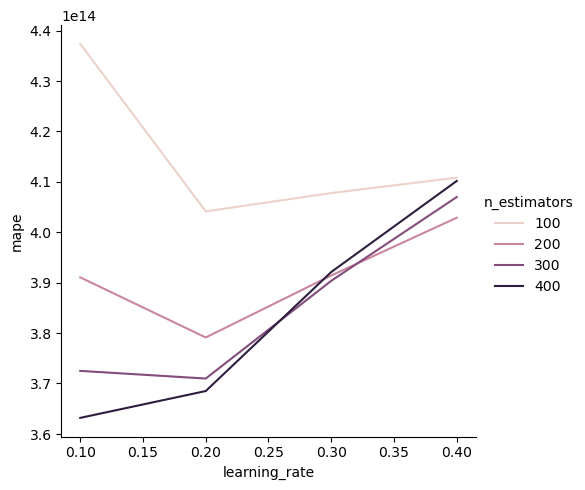

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

In [44]:
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate
optimal_n_jobs = grid_search.to_sklearn().best_estimator_.n_jobs


In [45]:
%%time

target_col=['INTERACTION']

best_classifier = XGBClassifier(
    input_cols = all_feature_cols_aux,
    label_cols = target_col,
    n_estimators = optimal_n_estimators,
    learning_rate = optimal_learning_rate,
    n_jobs = optimal_n_jobs,
    output_cols = 'PREDICTION'
)

best_classifier.fit(train_df2)

[07:58:21] WARNING: /opt/conda/conda-bld/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

CPU times: user 2.42 s, sys: 571 ms, total: 2.99 s
Wall time: 14min 8s


In [46]:
result2 = best_classifier.predict(test_df2)

The same way we did before, lets use Model Regisgry to registry the optimal model:

In [47]:
acc_score2 = accuracy_score(df = result2, y_true_col_names="INTERACTION", y_pred_col_names="PREDICTION")

In [48]:
print (f"Accuracy Score:{acc_score2}")  

Accuracy Score:0.914221


## Appendix A

There are different ways to perform pre-processing. A traditional one using Numpy arrays and pandas is presented here. Traditional DS woudl be acostum to use this way instead of using Snowflake reatures to transforma and pre-process data. It is shown here so we can see how much time is spent

In [58]:
def data_prep(df, feature_cols, target_col, training_frac, logger):
    """
    prep data for training: extract embeddings, transform categorical features
    """
    # Select feature columns
    X = df[feature_cols]
    # Extract embeddings and convert into dataframe
    logger.info(
        f"\tExtracting Embeddings. RAM memory % used: {psutil.virtual_memory()[2]}"
    )
    embedding_array = np.stack(X.EMBEDDINGS.apply(lambda x: np.array(eval(x))))
    logger.info(
        f"\tConverting Embeddings to pd.DataFrame. RAM memory % used: {psutil.virtual_memory()[2]}"
    )
    embeddings_only = pd.DataFrame(embedding_array, columns=['EMBEDDING_'+str(i)for i in range(512)])

    logger.info(
        f"\tConcating Embeddings. RAM memory % used: {psutil.virtual_memory()[2]}"
    )
    # combine embeddings and non-embedding features into single dataframe
    X = pd.concat([X.drop('EMBEDDINGS', axis=1), embeddings_only], axis=1)
    logger.info(
        f"\tRAM memory % used: {psutil.virtual_memory()[2]}"
    )
    # convert gender from string to binary feature
    X.GENDER = X.GENDER.apply(lambda x: x=='Female').astype(int)
    # 1-hot encode profession 
    profession_columns = [
        'PROFESSION_ARTIST','PROFESSION_DOCTOR','PROFESSION_ENGINEER',
        'PROFESSION_ENTERTAINMENT','PROFESSION_EXECUTIVE','PROFESSION_HEALTHCARE',
        'PROFESSION_HOMEMAKER','PROFESSION_LAWYER','PROFESSION_MARKETING'
    ]
    for c in profession_columns:
        X[c] = (X.PROFESSION == c[11:]).astype(int)
    X = X.drop('PROFESSION', axis=1)
    y = df[target_col]
    # create training subsample
    train_sample = X.sample(frac=training_frac).index
    return X, y, train_sample


In [59]:
import sys
import psutil

def get_logger():
    """
    Get a logger for local logging.
    """
    logger = logging.getLogger("job-tutorial")
    logger.setLevel(logging.DEBUG)
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

logger = get_logger()


In [60]:
%%time
table_name = "CLICKSTREAM_TRAIN_FULL"
feature_cols=['GENDER', 'AGE', 'PROFESSION', 'WORK_EXPERIENCE', 'ANNUAL_INCOME', 'SPENDING_SCORE', 'FAMILY_SIZE', 'EMBEDDINGS']


df_embeddings = session.table(table_name).to_pandas()

X, y, training_sample = data_prep(df_embeddings, feature_cols, target_col, 0.2,logger)

job-tutorial - INFO - 	Extracting Embeddings. RAM memory % used: 23.2
job-tutorial - INFO - 	Extracting Embeddings. RAM memory % used: 23.2
job-tutorial - INFO - 	Extracting Embeddings. RAM memory % used: 23.2


INFO:job-tutorial:	Extracting Embeddings. RAM memory % used: 23.2


job-tutorial - INFO - 	Converting Embeddings to pd.DataFrame. RAM memory % used: 42.2
job-tutorial - INFO - 	Converting Embeddings to pd.DataFrame. RAM memory % used: 42.2
job-tutorial - INFO - 	Converting Embeddings to pd.DataFrame. RAM memory % used: 42.2


INFO:job-tutorial:	Converting Embeddings to pd.DataFrame. RAM memory % used: 42.2


job-tutorial - INFO - 	Concating Embeddings. RAM memory % used: 42.2
job-tutorial - INFO - 	Concating Embeddings. RAM memory % used: 42.2
job-tutorial - INFO - 	Concating Embeddings. RAM memory % used: 42.2


INFO:job-tutorial:	Concating Embeddings. RAM memory % used: 42.2


job-tutorial - INFO - 	RAM memory % used: 51.5
job-tutorial - INFO - 	RAM memory % used: 51.5
job-tutorial - INFO - 	RAM memory % used: 51.5


INFO:job-tutorial:	RAM memory % used: 51.5


CPU times: user 4min 9s, sys: 6.33 s, total: 4min 16s
Wall time: 4min 14s


## Appendix B

In order to run this notebook within Snowpark Container Services, this is one example of docker file and yaml specification:


Docker File:

FROM nvcr.io/nvidia/rapidsai/rapidsai:23.06-cuda11.8-runtime-ubuntu22.04-py3.10

# Set the working directory
WORKDIR /notebooks

# For Jupyter only - remove once validated
EXPOSE  8888

RUN mkdir /notebooks/.local /notebooks/.cache && chmod 777 -R /notebooks
ADD ./requirements.txt /notebooks/

# Install the dependencies from the requirements.txt file
RUN pip install --no-cache-dir --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

manifest.yaml file:
    
spec:
  container:
  - name: nvidia-notebook
    image: sfseeurope-us-west-ccarrero-452.registry.snowflakecomputing.com/cc_llms/notebook/images/notebook4
    volumeMounts:
      - name: images
        mountPath: /notebooks/workspace/images
      - name: models
        mountPath: /notebooks/workspace/models
      - name: dshm
        mountPath: /dev/shm
  endpoint:
  - name: lab
    port: 8888
    public: true
  volume:
  - name: images
    source: "@image_stg"
    uid: 1000
    gid: 1000
  - name: models
    source: "@MODELS"
    uid: 1001
    gid: 1001
  - name: dshm
    source: memory
    size: 2Gi
